<a href="https://colab.research.google.com/github/wenjingni/Digital-Humanities/blob/master/POS_LSTM_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
data = pd.read_csv('input_encoding.txt',sep = ',')
data.head()

,Unnamed: 0,BookIndex,ChunkID,Author,POS,encoding
0,0,1400,0,Charles Dickens,PRON NOUN NOUN NOUN AUX PROPN PUNCT CCONJ PRON...,3 1 1 1 9 12 2 10 3 4 1 12 2 3 8 1 9 4 5 6 1 3...
1,1,1400,1,Charles Dickens,PRON ADJ ADV ADJ CCONJ ADJ NOUN ADP DET NOUN A...,3 8 7 8 10 8 1 5 6 1 5 1 1 5 3 11 9 9 4 5 6 8 ...
2,2,1400,2,Charles Dickens,ADV PUNCT PUNCT NOUN PUNCT NOUN ADV ADV PUNCT ...,7 2 2 1 2 1 7 7 2 2 4 6 1 2 4 5 3 2 4 3 1 2 2 ...
3,3,1400,3,Charles Dickens,PRON VERB PRON ADP PRON CCONJ DET NOUN ADP NOU...,3 4 3 5 3 10 6 1 5 1 2 13 6 1 4 5 3 2 10 3 9 7...
4,4,1400,4,Charles Dickens,ADV PUNCT PUNCT PUNCT PRON ADV VERB PUNCT ADP ...,7 2 2 2 3 7 4 2 5 12 2 4 3 1 15 2 2 4 3 2 4 7 ...


## Padding features,Tokenizing labels

In [ ]:
from keras.utils import to_categorical
author_id = list(data.Author.unique())
integer_mapping = {x: i for i,x in enumerate(author_id)}


In [ ]:
author_encoding = data.Author.map(integer_mapping)
data['Author_encoding'] = author_encoding
data.tail()

,Unnamed: 0,BookIndex,ChunkID,Author,POS,encoding,Author_encoding
17793,17793,5670,334,Virginia Woolf,CCONJ NOUN PUNCT INTJ PUNCT ADV ADJ PUNCT ADV ...,10 1 2 15 2 7 8 2 7 5 1 5 6 1 2 4 3 1 2 10 4 5...,9
17794,17794,5670,335,Virginia Woolf,PROPN PART NOUN AUX ADJ ADV PUNCT DET NOUN VER...,12 11 1 9 8 7 2 6 1 4 5 3 8 8 1 2 6 1 5 6 8 1 ...,9
17795,17795,5670,336,Virginia Woolf,PUNCT PRON AUX DET NOUN PUNCT PUNCT ADV PUNCT ...,2 3 9 6 1 2 2 7 2 7 7 2 3 4 6 8 1 2 13 13 8 1 ...,9
17796,17796,5670,337,Virginia Woolf,DET PRON NOUN VERB ADP ADP DET PRON PART VERB ...,6 3 1 4 5 5 6 3 11 4 2 3 9 3 4 2 9 3 4 3 9 4 7...,9
17797,17797,5670,338,Virginia Woolf,NOUN PUNCT NOUN AUX VERB DET NOUN ADP PROPN PU...,1 2 1 9 4 6 1 5 12 2 12 12 4 5 6 1 2 2 8 9 6 1...,9


## Training,Validation, Test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(data.encoding, data.Author_encoding, test_size=0.2, shuffle=True)

## Padding features
## Tokenizing labels

## Convert all training data into integers

In [ ]:
def pad_features(sequences,seq_length):
  ''' Return features of review_ints, where each review is padded with 0's
or truncated to the input seq_length.
'''
  features = np.zeros((len(sequences),seq_length),dtype=int)
  for i,row in enumerate(sequences):
    features[i,-len(row):] = np.array(row)[:seq_length]
  return features

In [ ]:
x_train_id = pad_features(x_train.str.split(),seq_length=128)
y_train_id = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='int')
x_valid_id = pad_features(x_valid.str.split(),seq_length=128)
y_valid_id = tf.keras.utils.to_categorical(y_valid, num_classes=10, dtype='int')

In [ ]:
x_train_id

array([[ 9,  3,  4, ...,  1,  9,  5],
       [ 0,  0,  0, ...,  5,  3,  2],
       [ 0,  0,  0, ...,  7,  2,  2],
       ...,
       [ 7,  8,  9, ...,  7,  2,  7],
       [ 0,  0,  0, ...,  3,  2,  2],
       [10,  6, 14, ..., 10,  1,  4]])

## wrapping training and validation data into dataset

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_id, y_train_id))
    .repeat()
    .shuffle(2048)
    .batch(64)
)


valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_id, y_valid_id))
    .batch(64)
    .cache()
)

In [ ]:
print("y_train_shape:", y_train.shape)
print("x_train_shape:", x_train.shape)
print("y_valid_shape:", y_valid.shape)
print("x_valid_shape:", x_valid.shape)

y_train_shape: (14238,)
x_train_shape: (14238,)
y_valid_shape: (3560,)
x_valid_shape: (3560,)


## Classifier: Bidirectional LSTM only

In [ ]:
#LSTM only
from keras import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout

vocabulary_size = 20
max_words = 128
embedding_size=64

model=Sequential()

model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words,trainable = False))

model.add(layers.Bidirectional(LSTM(64,return_sequences=True)))
model.add(layers.Bidirectional(LSTM(64)))

# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64,activation = 'sigmoid'))
model.add(Dense(10,activation = 'softmax'))
print(model.summary())


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 64)           1280      
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 128, 128)          66048     
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1290      
Total params: 167,434
Trainable params: 166,154
Non-trainable params: 1,280
_________________________________________________________________
None


## Classifier: 2D CNN before LSTM

In [ ]:
#A 2D CNN before LSTM
from keras import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout,Input
from keras.layers.convolutional import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten

vocabulary_size = 20
max_words = 128
embedding_size=100


model=Sequential()

#First embedding the input from (128,) to (128,100) in order to feed them into the LSTM
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

#reshape the input into (128,100,1) to feed it to the 2D CNN
model.add(tf.keras.layers.Reshape((128,100,1), input_shape=(128,100)))

#after padding = same, the output shape keeps the same as the input shape
model.add(Conv2D(filters = 128, kernel_size = 5, activation = 'relu',input_shape = (128,100,1),padding ='same'))

model.add(AveragePooling2D(pool_size=2,strides=2))
model.add((Flatten()))

#After flatten the convoluted values, reshape the output as the form of (batch size, features*timestep) from the pooled values, which
#has the shape of (64,50,1) -->1/2(128,100,1)
model.add(tf.keras.layers.Reshape((64,50*128), input_shape=(64,50,1)))

#Feed the output to the LSTM layer
model.add(layers.Bidirectional(LSTM(64,return_sequences=True)))
model.add(layers.Bidirectional(LSTM(64)))
model.add(Dense(10,activation = 'softmax'))

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 128, 100)          2000      
_________________________________________________________________
reshape_6 (Reshape)          (None, 128, 100, 1)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 100, 128)     3328      
_________________________________________________________________
average_pooling2d_4 (Average (None, 64, 50, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 409600)            0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 64, 6400)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64, 128)         

In [ ]:
#use this to make topK categorical accuracy as top3 categorical accuracy
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

In [ ]:
model.compile(Adam(lr=3e-5), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(Adam(lr=3e-5), loss='binary_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy',top3_acc])

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=100,
    validation_data=valid_dataset,
    epochs=10)

Epoch 1/10
100/100 [==============================] - 22s 108ms/step - loss: 0.6622 - accuracy: 0.0932 - val_loss: 0.3987 - val_accuracy: 0.0862
Epoch 2/10
100/100 [==============================] - 10s 95ms/step - loss: 0.3622 - accuracy: 0.0959 - val_loss: 0.3250 - val_accuracy: 0.1941
Epoch 3/10
100/100 [==============================] - 10s 96ms/step - loss: 0.3229 - accuracy: 0.1982 - val_loss: 0.3201 - val_accuracy: 0.1941
Epoch 4/10
100/100 [==============================] - 10s 97ms/step - loss: 0.3199 - accuracy: 0.1888 - val_loss: 0.3189 - val_accuracy: 0.1941
Epoch 5/10
100/100 [==============================] - 10s 97ms/step - loss: 0.3182 - accuracy: 0.2051 - val_loss: 0.3172 - val_accuracy: 0.1941
Epoch 6/10
100/100 [==============================] - 10s 98ms/step - loss: 0.3151 - accuracy: 0.2052 - val_loss: 0.3137 - val_accuracy: 0.1941
Epoch 7/10
100/100 [==============================] - 10s 99ms/step - loss: 0.3111 - accuracy: 0.2104 - val_loss: 0.3099 - val_accuracy

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'top3_acc' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['top3_acc'], 'b', label="training top3 acc ({:.4f})".format(history.history['top3_acc'][-1]))
        ax2.plot(history.history['val_top3_acc'], 'b--', label="validation top3 acc ({:.4f})".format(history.history['val_top3_acc'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('top3 acc', color='b')        
        ax2.tick_params('y', colors='b')

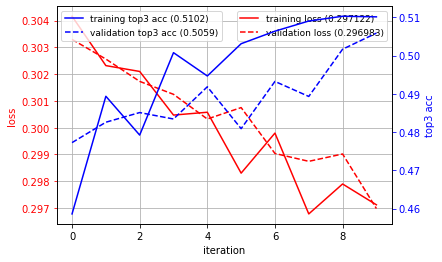

In [ ]:
plot_history(history)